The recommended dataset for ths recipe can be downloaded from here:
http://www.fki.inf.unibe.ch/DBs/iamDB/data/words/words.tgz

https://colab.research.google.com/drive/1y4nqFCLtQy3Vvn8qO1TQRlzPJSMb7cIa

In [0]:
!wget http://www.fki.inf.unibe.ch/DBs/iamDB/data/words/words.tgz

In [0]:
import cv2, numpy as np
def extract_img(img):
  target = np.ones((32,128))*255
  new_x = 32/img.shape[0]
  new_y = 128/img.shape[1]
  min_xy = min(new_x, new_y)
  new_x = int(img.shape[0]*min_xy)
  new_y = int(img.shape[1]*min_xy)
  img2 = cv2.resize(img, (new_y,new_x))
  target[:new_x,:new_y] = img2[:,:,0]
  target[new_x:,new_y:] = 255
  return 255-target

In [0]:
f = open('...') # Path to the output label file

In [0]:
import cv2
count = 0
x = []
y = []
x_new = []
chars = set()
im_path = []
for line in f:
    if not line or line[0]=='#':
        continue
    try:
        lineSplit = line.strip().split(' ')
        fileNameSplit = lineSplit[0].split('-')
        img_path = '/content/'+fileNameSplit[0]+'/'+fileNameSplit[0] + '-' + fileNameSplit[1]+'/'+lineSplit[0]+'.png'
        img_word = lineSplit[-1]
        img = cv2.imread(img_path)
        img2 = extract_img(img)
        x_new.append(img2)
        x.append(img)
        y.append(img_word)
        im_path.append(img_path)
        count+=1
    except:
        print(1)

1
1


In [0]:
import itertools
list2d = y
charList = list(set(list(itertools.chain(*list2d))))

In [0]:
num_images = 50000

In [0]:
import numpy as np
y2 = []
input_lengths = np.ones((num_images,1))*32
label_lengths = np.zeros((num_images,1))
for i in range(num_images):
    val = list(map(lambda x: charList.index(x), y[i]))
    while len(val)<32:
        val.append(79)
    y2.append(val)
    label_lengths[i] = len(y[i])
    input_lengths[i] = 32

In [0]:
input_lengths.shape, label_lengths.shape

((50000, 1), (50000, 1))

In [0]:
import numpy as np
x = np.asarray(x_new[:num_images])
y2 = np.asarray(y2)

In [0]:
len(x), len(y2)

(50000, 50000)

In [0]:
x.shape, y2.shape

((50000, 32, 128), (50000, 32))

In [0]:
x = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
x.shape

(50000, 32, 128, 1)

In [0]:
import numpy as np
outputs = {'ctc': np.zeros([32])}

In [0]:
import keras.backend as K
def ctc_loss(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [0]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras.layers import Dense, Input, GlobalMaxPooling1D,Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Convolution2D, MaxPooling2D,Conv2D, Reshape, GRU, TimeDistributed, Lambda
from keras.models import Model
import random
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM , Bidirectional,Dropout
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras.layers.merge import add, concatenate

In [0]:
input_data = Input(name='the_input', shape = (32, 128,1), dtype='float32')

In [0]:
inner = Conv2D(32, (3,3), padding='same')(input_data)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2),name='max1')(inner)

inner = Conv2D(64, (3,3), padding='same')(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2),name='max2')(inner)

inner = Conv2D(128, (3,3), padding='same')(input_data)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2),name='max3')(inner)

inner = Conv2D(128, (3,3), padding='same')(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2),name='max4')(inner)

inner = Conv2D(256, (3,3), padding='same')(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(4,2),name='max5')(inner)

inner = Reshape(target_shape = ((32,256)), name='reshape')(inner)

gru_1 = GRU(256, return_sequences = True, name = 'gru_1')(inner)
gru_2 = GRU(256, return_sequences = True, go_backwards = True, name = 'gru_2')(inner)

mix_1 = add([gru_1, gru_2])

gru_3 = GRU(256, return_sequences = True, name = 'gru_3')(inner)
gru_4 = GRU(256, return_sequences = True, go_backwards = True, name = 'gru_4')(inner)

merged = concatenate([gru_3, gru_4])

dense = TimeDistributed(Dense(80))(merged)
y_pred = TimeDistributed(Activation('softmax', name='softmax'))(dense)

Model(inputs = input_data, outputs = y_pred).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 32, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 128, 128) 1280        the_input[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 32, 128, 128) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
max3 (MaxPooling2D)             (None, 16, 64, 128)  0           activation_8[0][0]               
__________________________________________________________________________________________________
conv2d_9 (

In [0]:
from keras.optimizers import Adam
Optimizer = Adam()
labels = Input(name = 'the_labels', shape=[32], dtype='float32')
input_length = Input(name='input_length', shape=[1],dtype='int64')
label_length = Input(name='label_length',shape=[1],dtype='int64')
output = Lambda(ctc_loss, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length])

In [0]:
model = Model(inputs = [input_data, labels, input_length, label_length], outputs= output)

In [0]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = Optimizer)

In [0]:
!apt install graphviz
!pip install pydot pydot-ng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


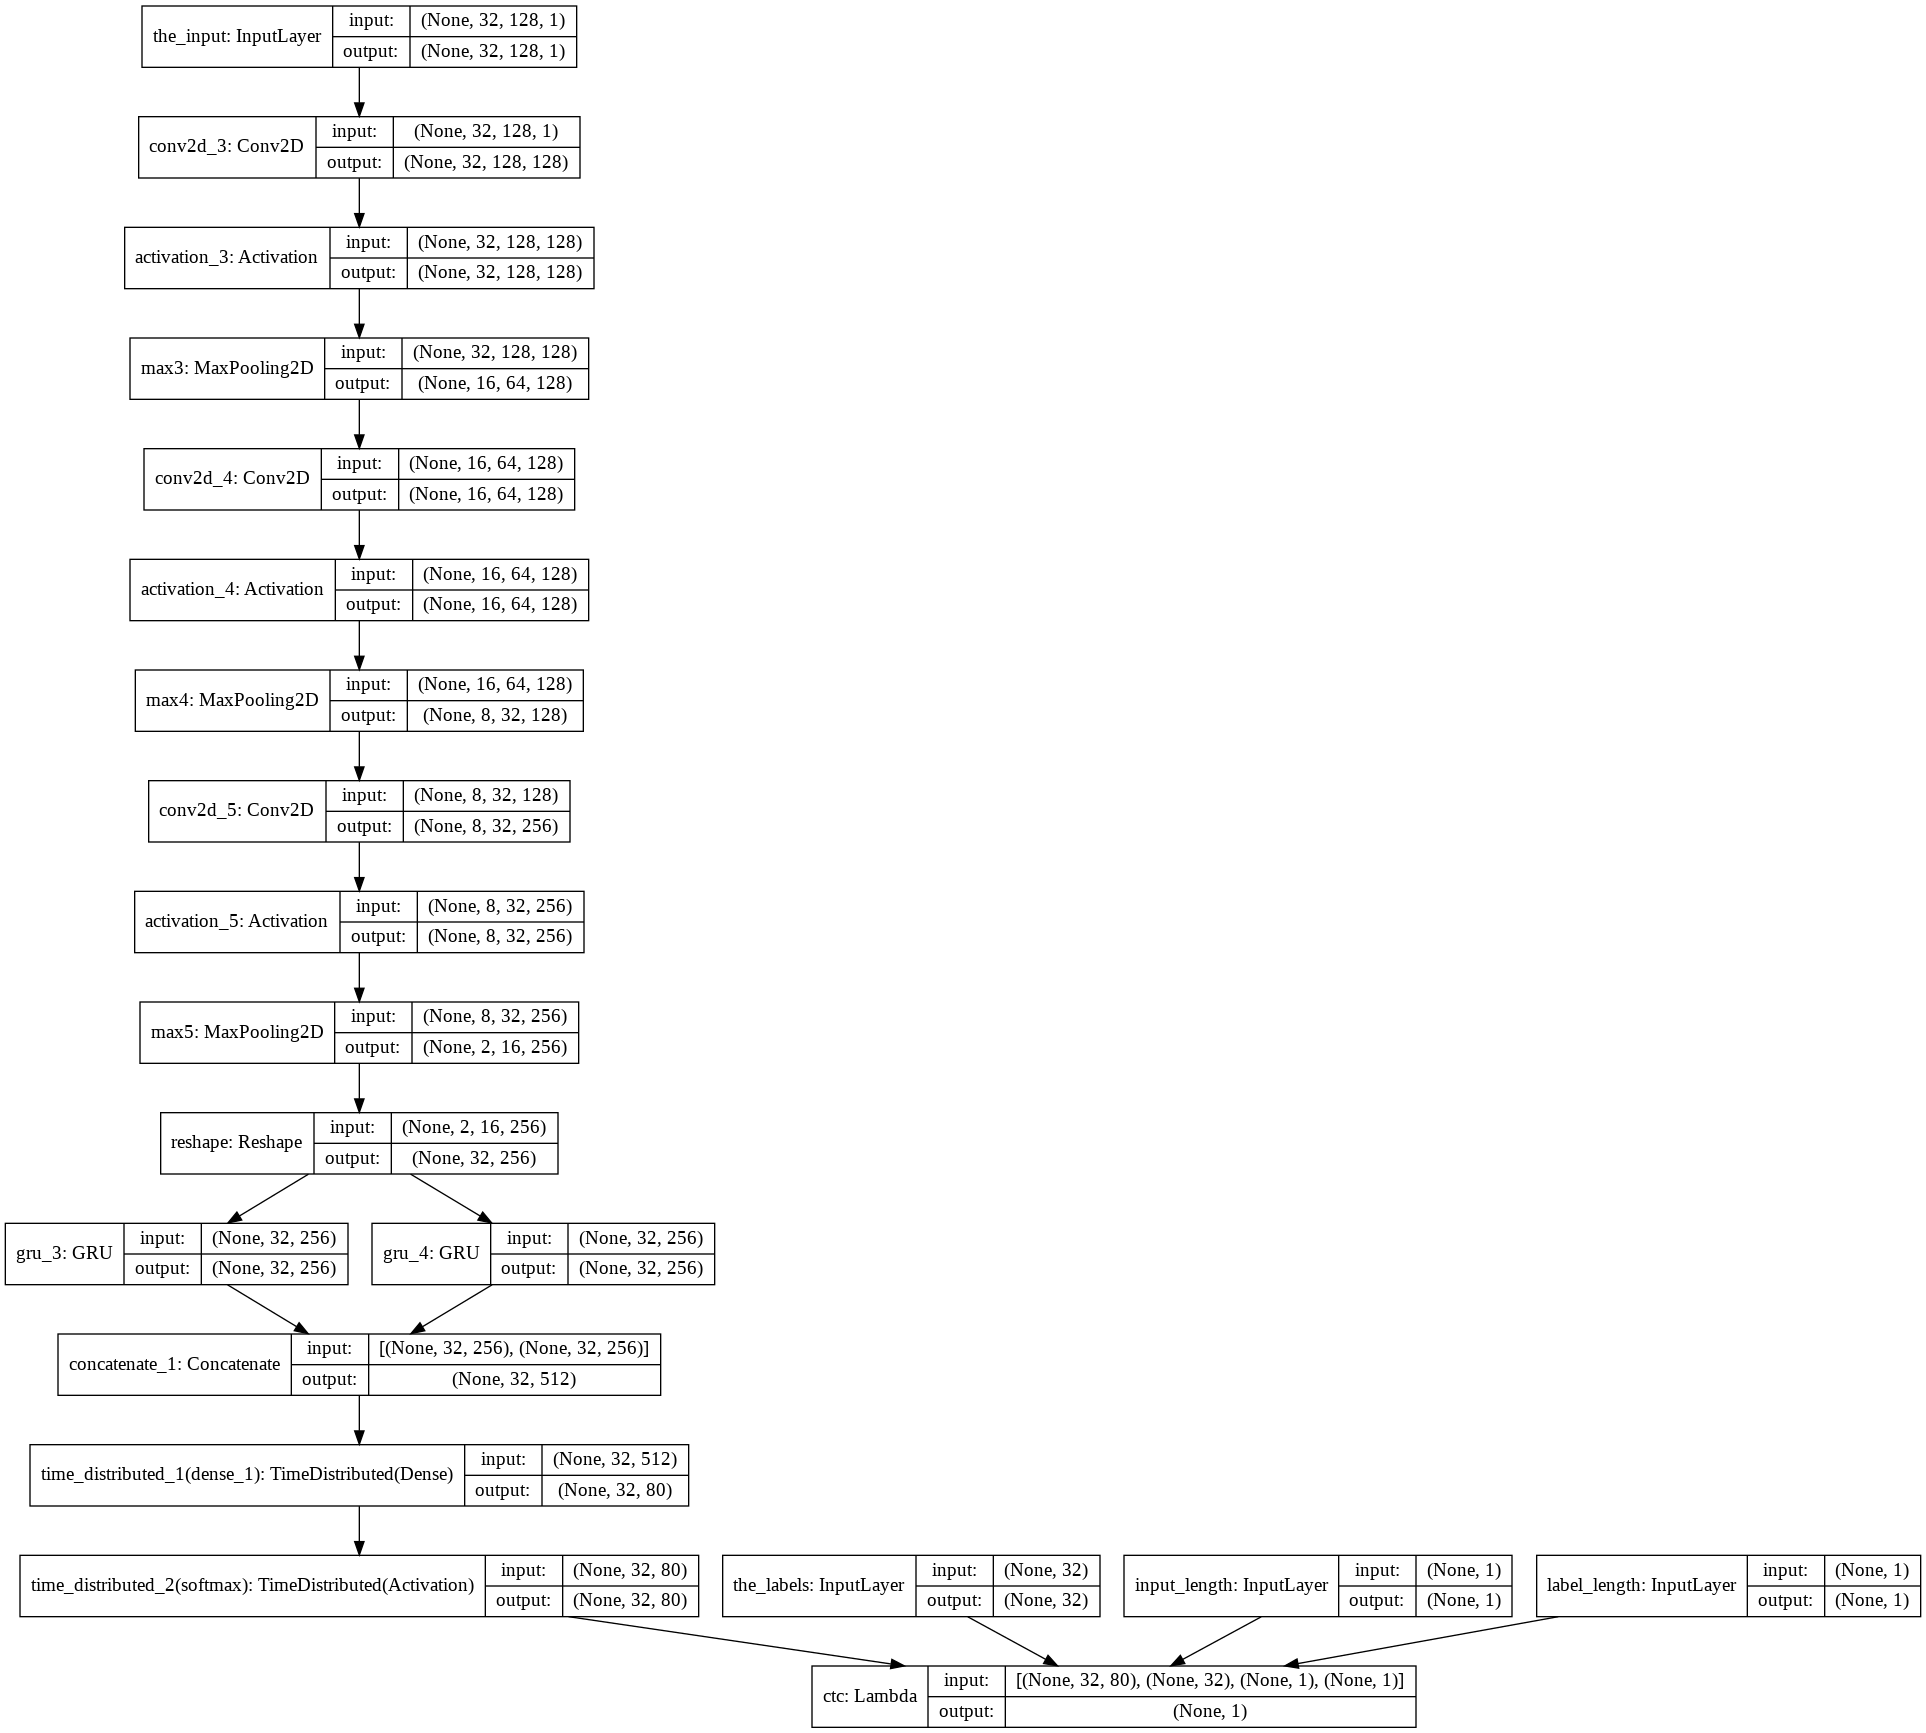

In [0]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
from google.colab import files
files.download('/content/model.png') 

In [0]:
x2 = np.array(x[:num_images])/255

In [0]:
#x2 = np.where(x2<0.5,0,1)

In [0]:
x2.shape

(50000, 32, 128, 1)

In [0]:
x2.shape

(50000, 32, 128, 1)

In [0]:
y2 = np.array(y2[:num_images])

In [0]:
y2 = np.asarray(y2)

In [0]:
input_lengths = input_lengths[:num_images]
label_lengths = label_lengths[:num_images]

In [0]:
import random

In [0]:
np.mean(x2)

0.07953359250536106

In [0]:
l = []

In [0]:
for i in range(5000):
#   if(i%10==0):
#     print(i)
  samp=random.sample(range(x2.shape[0]-100),32)

  x3=[x2[i] for i in samp]
  x3 = np.array(x3)
  y3 = [y2[i] for i in samp]
  y3 = np.array(y3)
  input_lengths2 = [input_lengths[i] for i in samp]
  label_lengths2 = [label_lengths[i] for i in samp]

  input_lengths2 = np.array(input_lengths2)
  label_lengths2 = np.array(label_lengths2)

  inputs = {
    'the_input': x3,
    'the_labels': y3,
    'input_length': input_lengths2,
    'label_length': label_lengths2,
  }

  outputs = {'ctc': np.zeros([32])}
  
  if(i%100==0):
    print(i)
    history1 = model.fit(inputs, outputs,batch_size = 32, epochs=1, verbose =2)
    l.append(history1.history['loss'][0])
    
  else:
    history2 = model.fit(inputs, outputs,batch_size = 32, epochs=1, verbose =0)
    l.append(history2.history['loss'][0])


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


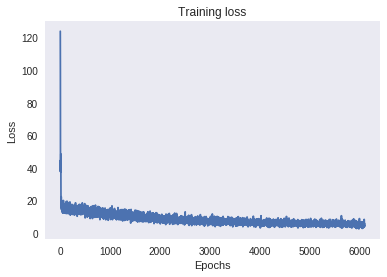

In [0]:
plt.plot(l)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

In [0]:
model2 = Model(inputs = input_data, outputs = y_pred)

In [0]:
k=-50
pred= model2.predict(x2[k].reshape(1,32,128,1))

In [0]:
pred2 = np.argmax(pred[0,:],axis=1)
out = ""
for i in pred2:
  if(i==79):
    continue
  else:
    out += charList[i]
    #print(charList[i])

plt.imshow(x2[k].reshape(32,128))
plt.title('Predicted word:  '+out)
plt.grid('off')

In [0]:
pred2 = np.argmax(pred[0,:],axis=1)
out = ""
for i in pred2:
  if(i==79):
    continue
  else:
    out += charList[i]
    #print(charList[i])

plt.imshow(x2[k].reshape(32,128))
plt.title('Predicted word:  '+out)
plt.grid('off')

In [0]:
np.argmax(pred[0,:],axis=1)

array([41, 79, 79, 79, 32, 79,  2, 79, 79, 70,  0, 79,  2, 79, 48, 79, 79,
       79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79])

In [0]:
out

wending
